# 커스텀 데이터 영상 분류 학습

# 데이터 준비


<br>

데이터는 다음과 같이 구성됨

```
dogs/
    train/
        class1/
            file1.jpg
            file2.jpg
             ...
        class2/ 
            file21.jpg
            file22.jpg
             ...    
        class3/
            file31.jpg
            file32.jpg
             ...
        ...
    test/
        class1/
            file8.jpg
            file9.jpg
             ...
        class2/ 
            file28.jpg
            file29.jpg
             ...    
        class3/
            file38.jpg
            file39.jpg
             ...
        ...
    
```

In [16]:
!rm -rf dogs_prepared.tar.gz
!wget https://github.com/dhrim/cau_2021/raw/master/material/deep_learning/dogs_prepared.tar.gz
!ls -al  

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
--2021-10-27 00:35:27--  https://github.com/dhrim/cau_2021/raw/master/material/deep_learning/dogs_prepared.tar.gz
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/cau_2021/master/material/deep_learning/dogs_prepared.tar.gz [following]
--2021-10-27 00:35:27--  https://raw.githubusercontent.com/dhrim/cau_2021/

In [17]:
!rm -rf dogs_prepared
!tar xvfz dogs_prepared.tar.gz
!ls -al dogs_prepared

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
dogs_prepared/
dogs_prepared/._test
dogs_prepared/test/
dogs_prepared/train/
dogs_prepared/train/n02085620-Chihuahua/
dogs_prepared/train/n02085782-Japanese_spaniel/
dogs_prepared/train/n02085936-Maltese_dog/
dogs_prepared/train/n02086079-Pekinese/
dogs_prepared/train/n02086240-Shih-Tzu/
dogs_prepared/train/n02086646-Blenheim_spaniel/
dogs_prepared/train/n02086910-papillon/
dogs_prepared/train/n02087046-toy_terrier/
dogs_prepared/train/n02087394-Rhodesian_ridgeback/
dogs_prep

# 모델 학습

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_4 (Flatten)          (None, 68992)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               17662208  
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
model_output (Dense)         (None, 10)                2570      
Total params: 25,434,371
Trainable params: 17,665,290
Non-trainable params: 7,769,081
_________________________________________________________________
Found 1531 images belonging to 10 classes.
Found 388 images belonging to 10 classes.
Epoch 1/10
24/2

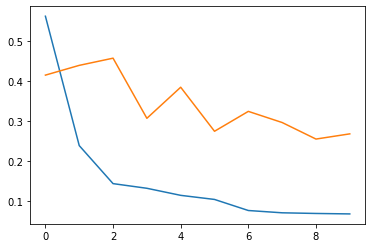

7/7 [==============================] - 1s 183ms/step - loss: 0.2678 - acc: 0.9407
loss= 0.2677649259567261
acc= 0.9407216310501099


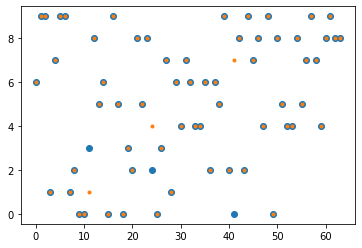

label category index = 6.0
predicted category index = 6
predicted category name = n02086910-papillon


In [27]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False
conv_layers._name = "model"

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax', name="model_output"))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "dogs_prepared/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "dogs_prepared/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



test_x, test_y = test_data_generator.next()
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", test_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


# 레이블링 파일 작성

In [38]:
f = open("labels.txt", "w")
f.write("\n".join(custom_labels))
f.close()

In [40]:
!cat labels.txt

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound

# 모델을 tf 포멧으로 저장

In [28]:
import os
import tensorflow as tf

model.save("model.tf", save_format="tf")

INFO:tensorflow:Assets written to: model.tf/assets


# tf2onnx 설치


In [6]:
!pip3 install tf2onnx

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


# 모델을 onnx로 변환

In [32]:
!python -m tf2onnx.convert --opset 10 --saved-model model.tf --output model.onnx --inputs model_input:0[1,224,224,3]

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-10-27 00:59:38,164 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2021-10-27 00:59:38,640 - WARNING - Importing a function (__inference_block5d_activation_layer_call_and_return_conditional_losses_268573) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-10-27 00:59:38,673 - WARNING - Importing a function (__inference_block4d_se_reduce_layer_call_and_return_conditional_losses_266913) with ops with cus